In [1]:
#assumptions that will break if we use MCTS for play traces in this code
#1. Turn wont be either 0 or 1
#2. Cant just copy the final two rows to extend round number to maxNoOfRounds

#comments: So play traces for a given strategy will change dependent on the opponent's strategy, e.g. evolution of 
#bigmoney deck is different if it is played vs another bigmoney startegy as opposed to say a witch strategy which will 
#introduce curse cards into the bigmoney trace

In [2]:
import pandas as pd
import pdb
import math
import matplotlib.pyplot as plt
from sklearn.manifold import MDS 
import itertools
pd.set_option('display.max_rows', 100)
noPlayers = 2

In [3]:
data  = pd.read_csv("data/featureslogfile.txt", sep = '\t')

In [4]:
print(data.columns)

Index(['GameID', 'Player', 'Round', 'Turn', 'CurrentScore', 'SCORE',
       'SCORE_ADV', 'ORDINAL', 'OUR_TURN', 'HAS_WON', 'FINAL_ORD', 'ROUND',
       'CURSE', 'ESTATE', 'DUCHY', 'PROVINCE', 'COPPER', 'SILVER', 'GOLD',
       'CELLAR', 'CHAPEL', 'MOAT', 'HARBINGER', 'MERCHANT', 'VASSAL',
       'VILLAGE', 'WORKSHOP', 'BUREAUCRAT', 'GARDENS', 'MILITIA',
       'MONEYLENDER', 'POACHER', 'REMODEL', 'SMITHY', 'THRONE_ROOM', 'BANDIT',
       'COUNCIL_ROOM', 'FESTIVAL', 'LABORATORY', 'LIBRARY', 'MARKET', 'MINE',
       'SENTRY', 'WITCH', 'ARTISAN', 'PlayerCount', 'TotalRounds',
       'ActionScore', 'Win', 'Ordinal', 'FinalScore'],
      dtype='object')


In [5]:
#check number of games
print(data['GameID'].unique())

[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51.]


In [6]:
#note that Player field swaps round half way through the tournament when there are two players. Also the GameID starts
#at 2 for some reason
noGamesPerMatchUp = 25
def assignName(gameID, player, noGamesPerMatchUp):
    name = ""
    if gameID < (noGamesPerMatchUp + 2):
        if player == 0:
            name = 'BigMoneyWithGardens'
        else:
            name = 'DoubleWitch'
    else:
        if player == 1:
            name = 'BigMoneyWithGardens'
        else:
            name = 'DoubleWitch'
    return name

In [7]:
#add label for player types
data['PlayerName'] = data.apply(lambda df: assignName(df['GameID'], df['Player'], noGamesPerMatchUp), axis = 1)

In [8]:
print(data['GameID'].unique())

[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51.]


In [9]:
#we can only record events each turn so we need to use the final turn in each round for each player to determine their
#deck at the end of the round
print(data['Turn'].unique())
data = data[data['Turn'] == 1]
print(data['Turn'].unique())

[0. 1.]
[1.]


In [10]:
#extract columns of interest 
card_types_in_supply = ['ARTISAN', 'BANDIT', 'BUREAUCRAT', 'CHAPEL', 'FESTIVAL', 'GARDENS', 'SENTRY',
                        'THRONE ROOM', 'WITCH', 'CURSE','WORKSHOP','PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_BigMoneyWithGardens_vs_DoubleWitch = ['GARDENS', 'WITCH', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']

In [11]:
#define columns of interest
cols = ['PlayerName', 'Player', 'GameID', 'Round', 'CurrentScore']
cols = cols + card_types_BigMoneyWithGardens_vs_DoubleWitch

In [12]:
#extract all BigMoneyWithGardens play-traces
Traces_BigMoneyWithGardens = data[data['PlayerName'] == 'BigMoneyWithGardens'].loc[:, cols]
print(Traces_BigMoneyWithGardens)

               PlayerName  Player  GameID  Round  CurrentScore  GARDENS  \
2     BigMoneyWithGardens     0.0     2.0    0.0           3.0      0.0   
6     BigMoneyWithGardens     0.0     2.0    1.0           3.0      0.0   
10    BigMoneyWithGardens     0.0     2.0    2.0           3.0      0.0   
14    BigMoneyWithGardens     0.0     2.0    3.0           3.0      0.0   
18    BigMoneyWithGardens     0.0     2.0    4.0           3.0      0.0   
...                   ...     ...     ...    ...           ...      ...   
4337  BigMoneyWithGardens     1.0    51.0   14.0          -1.0      0.0   
4341  BigMoneyWithGardens     1.0    51.0   15.0          -1.0      0.0   
4345  BigMoneyWithGardens     1.0    51.0   16.0           4.0      0.0   
4349  BigMoneyWithGardens     1.0    51.0   17.0          10.0      0.0   
4353  BigMoneyWithGardens     1.0    51.0   18.0          15.0      0.0   

      WITCH  CURSE  PROVINCE  DUCHY  ESTATE  GOLD  SILVER  COPPER  
2       0.0    0.0       0.0   

In [13]:
#some sense checks
print(Traces_BigMoneyWithGardens['WITCH'].unique())
print(Traces_BigMoneyWithGardens['GameID'].unique())

[0.]
[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51.]


In [14]:
#extract all DoubleWitch play-traces
Traces_DoubleWitch = data[data['PlayerName'] == 'DoubleWitch'].loc[:, cols]
print(Traces_DoubleWitch)

       PlayerName  Player  GameID  Round  CurrentScore  GARDENS  WITCH  CURSE  \
3     DoubleWitch     1.0     2.0    0.0           3.0      0.0    0.0    0.0   
7     DoubleWitch     1.0     2.0    1.0           3.0      0.0    0.0    0.0   
11    DoubleWitch     1.0     2.0    2.0           3.0      0.0    1.0    0.0   
15    DoubleWitch     1.0     2.0    3.0           3.0      0.0    2.0    0.0   
19    DoubleWitch     1.0     2.0    4.0           3.0      0.0    2.0    0.0   
...           ...     ...     ...    ...           ...      ...    ...    ...   
4336  DoubleWitch     0.0    51.0   14.0          15.0      0.0    2.0    0.0   
4340  DoubleWitch     0.0    51.0   15.0          15.0      0.0    2.0    0.0   
4344  DoubleWitch     0.0    51.0   16.0          21.0      0.0    2.0    0.0   
4348  DoubleWitch     0.0    51.0   17.0          21.0      0.0    2.0    0.0   
4352  DoubleWitch     0.0    51.0   18.0          27.0      0.0    2.0    0.0   

      PROVINCE  DUCHY  ESTA

In [15]:
#all play taces in a single data frame
traces = data.loc[:, cols]
print(traces)

               PlayerName  Player  GameID  Round  CurrentScore  GARDENS  \
2     BigMoneyWithGardens     0.0     2.0    0.0           3.0      0.0   
3             DoubleWitch     1.0     2.0    0.0           3.0      0.0   
6     BigMoneyWithGardens     0.0     2.0    1.0           3.0      0.0   
7             DoubleWitch     1.0     2.0    1.0           3.0      0.0   
10    BigMoneyWithGardens     0.0     2.0    2.0           3.0      0.0   
...                   ...     ...     ...    ...           ...      ...   
4345  BigMoneyWithGardens     1.0    51.0   16.0           4.0      0.0   
4348          DoubleWitch     0.0    51.0   17.0          21.0      0.0   
4349  BigMoneyWithGardens     1.0    51.0   17.0          10.0      0.0   
4352          DoubleWitch     0.0    51.0   18.0          27.0      0.0   
4353  BigMoneyWithGardens     1.0    51.0   18.0          15.0      0.0   

      WITCH  CURSE  PROVINCE  DUCHY  ESTATE  GOLD  SILVER  COPPER  
2       0.0    0.0       0.0   

In [16]:
#we need to make sure all games have the same number of rounds in them
gameLengths = traces.groupby(['GameID'])['Round'].max()
maxNoOfRounds = int(gameLengths.max()) + 1 #round counter starts at zero
print(maxNoOfRounds)

25


In [17]:
def copy_final_deck_at_game_end(group, roundMax, noPlayers):
    #This function repeatedly copies the final decks of two players at the game end, so that the game is extended to 
    #have roundMax rounds
    final_round = int(group['Round'].max())
    if (roundMax-1) == final_round:
        #in this case we dont need to extend the play trace
        return group
    else:
        final_row_copy = pd.concat([group.iloc[-noPlayers:]] * ((roundMax-1) - final_round), ignore_index=True)
        #we need to update the Round counter so that every other row it increments by one
        final_row_copy['Round'] = [final_round + 1 + i // 2 for i in range(((roundMax-1) - final_round)*2)]
        return pd.concat([group, final_row_copy], ignore_index=True)

In [18]:
extended_traces = traces.groupby('GameID').apply(copy_final_deck_at_game_end, maxNoOfRounds, noPlayers = 2).reset_index(drop = True)
print(extended_traces)

               PlayerName  Player  GameID  Round  CurrentScore  GARDENS  \
0     BigMoneyWithGardens     0.0     2.0    0.0           3.0      0.0   
1             DoubleWitch     1.0     2.0    0.0           3.0      0.0   
2     BigMoneyWithGardens     0.0     2.0    1.0           3.0      0.0   
3             DoubleWitch     1.0     2.0    1.0           3.0      0.0   
4     BigMoneyWithGardens     0.0     2.0    2.0           3.0      0.0   
...                   ...     ...     ...    ...           ...      ...   
2495  BigMoneyWithGardens     1.0    51.0   22.0          15.0      0.0   
2496          DoubleWitch     0.0    51.0   23.0          27.0      0.0   
2497  BigMoneyWithGardens     1.0    51.0   23.0          15.0      0.0   
2498          DoubleWitch     0.0    51.0   24.0          27.0      0.0   
2499  BigMoneyWithGardens     1.0    51.0   24.0          15.0      0.0   

      WITCH  CURSE  PROVINCE  DUCHY  ESTATE  GOLD  SILVER  COPPER  
0       0.0    0.0       0.0   

In [19]:
noOfGames = extended_traces['GameID'].unique().size
noOfOffDiagGameCombos = int(noOfGames *(noOfGames -1)/2.0) #for each off diag set of games there are 4 combinations of
#player strategies (e.g. for games 2 and 3, we can compare bigmoney vs bigmoney, bigmoney vs singlewitch etc)
#for 'diagonal' set of games there is just the one trace comparison available
noOfPairWiseDistances = noOfOffDiagGameCombos * 4 + noOfGames
print(noOfPairWiseDistances)

4950


In [20]:
#next we need to collect together all pairwise combinations of traces so that we can compute a distance measure

# Step 1: Create a list of DataFrames for each 'off diagonal' combination of games
unique_values = extended_traces['GameID'].unique()
offdiag_combinations = list(itertools.combinations(unique_values, 2))
diag_combos = [(i,i) for i in unique_values]
combos = offdiag_combinations + diag_combos

list_dfs = []
for combination in combos:
    #extract traces for each game ID and strategy combination
    GameID_1, GameID_2 = combination
    keys = []
    if GameID_1 != GameID_2:
        keys = [((GameID_1, 'BigMoneyWithGardens'), (GameID_2, 'BigMoneyWithGardens')),
                ((GameID_1, 'BigMoneyWithGardens'), (GameID_2, 'DoubleWitch')),
                ((GameID_1, 'DoubleWitch'), (GameID_2, 'BigMoneyWithGardens')),
                ((GameID_1, 'DoubleWitch'), (GameID_2, 'DoubleWitch'))]
    else:
        keys = [((GameID_1, 'BigMoneyWithGardens'), (GameID_1, 'DoubleWitch'))]
             
    for key in keys:
        key1, key2 = key
        game1,player1 = key1
        game2,player2 = key2
        
        #get data for key 1
        df_A = extended_traces[(extended_traces['GameID'] == game1) & (extended_traces['PlayerName'] == player1)]
        df_1 = df_A.rename(columns={'PlayerName' : 'PlayerName_1', 'Player': 'Player_1', 'GameID': 'GameID_1', 
                                                     'CurrentScore': 'CurrentScore_1', 'GARDENS': 'GARDENS_1',
                                                     'WITCH': 'WITCH_1', 'CURSE': 'CURSE_1','PROVINCE': 'PROVINCE_1',
                                                     'DUCHY':'DUCHY_1', 'ESTATE': 'ESTATE_1', 'GOLD': 'GOLD_1', 
                                                     'SILVER':'SILVER_1', 'COPPER':'COPPER_1'})
        #next add opponents name for future reference
        playerNo = (int)(df_1['Player_1'].unique()[0])
        OpponentNo = 0
        if playerNo == 0:
            OpponentNo = 1
        else:
            OpponentNo = 0   
        df_1['Opponent_1'] = [OpponentNo] * len(df_1['Player_1']) 
        df_1['OpponentName_1'] = df_1.apply(lambda df: assignName(df['GameID_1'], df['Opponent_1'], noGamesPerMatchUp), axis = 1)
        
        #get data for key 2
        df_B = extended_traces[(extended_traces['GameID'] == game2) & (extended_traces['PlayerName'] == player2)]
        df_2 = df_B.rename(columns={'PlayerName' : 'PlayerName_2', 'Player': 'Player_2', 'GameID': 'GameID_2', 
                                                     'CurrentScore': 'CurrentScore_2', 'GARDENS': 'GARDENS_2',
                                                     'WITCH': 'WITCH_2', 'CURSE': 'CURSE_2','PROVINCE': 'PROVINCE_2',
                                                     'DUCHY':'DUCHY_2', 'ESTATE': 'ESTATE_2', 'GOLD': 'GOLD_2', 
                                                     'SILVER':'SILVER_2', 'COPPER':'COPPER_2'})
        
        #add opponents name again
        playerNo = (int)(df_2['Player_2'].unique()[0])
        OpponentNo = 0
        if playerNo == 0:
            OpponentNo = 1
        else:
            OpponentNo = 0   
        df_2['Opponent_2'] = [OpponentNo] * len(df_2['Player_2']) 
        df_2['OpponentName_2'] = df_2.apply(lambda df: assignName(df['GameID_2'], df['Opponent_2'], noGamesPerMatchUp), axis = 1)
        
        #next align play traces by linking the common round column
        df_3 = pd.merge(df_1, df_2, on = 'Round')
        
        #then add to list of dfs
        list_dfs.append(df_3)
        
#finally we need to append togther all the datafarmes in our list
sym_trace_combos = pd.concat(list_dfs, ignore_index=True)

In [21]:
#the no of rows in our symmetric trace combos should be given by noOfPairwiseDistances * maxNoRounds
print(noOfPairWiseDistances * maxNoOfRounds)
sym_trace_combos.shape

123750


(123750, 31)

In [22]:
#next step is to calculate the distance between the decks at each round for each given pair of play traces
def deck_dist_measure(playTracePairForSingleRound, cardTypes):
    dist = 0
    for card in cardTypes:
        col1 = card + "_1"
        col2 = card + "_2"
        dist += (playTracePairForSingleRound[col1]-playTracePairForSingleRound[col2])**2
    dist = math.sqrt(dist)/math.sqrt(len(cardTypes))
    return dist

In [23]:
sym_trace_combos['dist'] = sym_trace_combos.apply(lambda row: deck_dist_measure(row, card_types_BigMoneyWithGardens_vs_DoubleWitch), axis = 1)

In [24]:
#examine evolution of deck distance in a few examples
game1 = 2
game2 = 3
player1 = 'BigMoneyWithGardens'
player2 = 'DoubleWitch'
#player2 = 'DoubleWitch'
example = sym_trace_combos[(sym_trace_combos['GameID_1'] == game1) & (sym_trace_combos['GameID_2'] == game2) &
                           (sym_trace_combos['PlayerName_1'] == player1) & (sym_trace_combos['PlayerName_2'] == player2)]
print(example)

           PlayerName_1  Player_1  GameID_1  Round  CurrentScore_1  GARDENS_1  \
25  BigMoneyWithGardens       0.0       2.0    0.0             3.0        0.0   
26  BigMoneyWithGardens       0.0       2.0    1.0             3.0        0.0   
27  BigMoneyWithGardens       0.0       2.0    2.0             3.0        0.0   
28  BigMoneyWithGardens       0.0       2.0    3.0             3.0        0.0   
29  BigMoneyWithGardens       0.0       2.0    4.0             3.0        0.0   
30  BigMoneyWithGardens       0.0       2.0    5.0             2.0        0.0   
31  BigMoneyWithGardens       0.0       2.0    6.0             1.0        0.0   
32  BigMoneyWithGardens       0.0       2.0    7.0             1.0        0.0   
33  BigMoneyWithGardens       0.0       2.0    8.0             0.0        0.0   
34  BigMoneyWithGardens       0.0       2.0    9.0             0.0        0.0   
35  BigMoneyWithGardens       0.0       2.0   10.0             0.0        0.0   
36  BigMoneyWithGardens     

In [25]:
#next we need to define the distance between play traces based on the distance between decks at each round
def trace_dist_measure(playTracePairForAllRounds, maxRounds):
    return playTracePairForAllRounds['dist'].sum()/maxRounds

In [26]:
#now compute all the pairwise trace distances
pairwiseTraceDistances = sym_trace_combos[['GameID_1','GameID_2','PlayerName_1','PlayerName_2','dist']]
pairwiseTraceDistances = pairwiseTraceDistances.groupby(['GameID_1','GameID_2','PlayerName_1','PlayerName_2'])['dist'].sum()
df_pairwiseTraceDistances = pairwiseTraceDistances.reset_index()

In [27]:
print(df_pairwiseTraceDistances)

      GameID_1  GameID_2         PlayerName_1         PlayerName_2       dist
0          2.0       2.0  BigMoneyWithGardens          DoubleWitch  45.932217
1          2.0       3.0  BigMoneyWithGardens  BigMoneyWithGardens  10.408512
2          2.0       3.0  BigMoneyWithGardens          DoubleWitch  48.121423
3          2.0       3.0          DoubleWitch  BigMoneyWithGardens  52.445052
4          2.0       3.0          DoubleWitch          DoubleWitch  18.206014
...        ...       ...                  ...                  ...        ...
4945      50.0      51.0  BigMoneyWithGardens  BigMoneyWithGardens  42.291493
4946      50.0      51.0  BigMoneyWithGardens          DoubleWitch  58.899209
4947      50.0      51.0          DoubleWitch  BigMoneyWithGardens  43.492235
4948      50.0      51.0          DoubleWitch          DoubleWitch  15.680529
4949      51.0      51.0  BigMoneyWithGardens          DoubleWitch  34.579398

[4950 rows x 5 columns]


In [28]:
#next look at average distances between similar and different strategies as an initial sense check
BMBM = df_pairwiseTraceDistances['dist'][(df_pairwiseTraceDistances['PlayerName_1'] == 'BigMoneyWithGardens') &
                                        (df_pairwiseTraceDistances['PlayerName_2'] == 'BigMoneyWithGardens')]
BMDW = df_pairwiseTraceDistances['dist'][(df_pairwiseTraceDistances['PlayerName_1'] == 'BigMoneyWithGardens') &
                                        (df_pairwiseTraceDistances['PlayerName_2'] == 'DoubleWitch') |
                                        (df_pairwiseTraceDistances['PlayerName_1'] == 'DoubleWitch') &
                                        (df_pairwiseTraceDistances['PlayerName_2'] == 'BigMoneyWithGardens')]
DWDW = df_pairwiseTraceDistances['dist'][(df_pairwiseTraceDistances['PlayerName_1'] == 'DoubleWitch') &
                                        (df_pairwiseTraceDistances['PlayerName_2'] == 'DoubleWitch')]
print(len(BMBM) + len(BMDW) + len(DWDW))
print("Mean BMBM: " + str(round(BMBM.mean(),2)))
print("Mean DWDW: " + str(round(DWDW.mean(),2)))
print("Mean BMDW: " + str(round(BMDW.mean(),2)))
print("Std BMBM: " + str(round(BMBM.std(),2)))
print("Std DWDW: " + str(round(DWDW.std(),2)))
print("Std BMDW: " + str(round(BMDW.std(),2)))

4950
Mean BMBM: 24.43
Mean DWDW: 18.07
Mean BMDW: 50.81
Std BMBM: 10.88
Std DWDW: 6.35
Std BMDW: 6.7


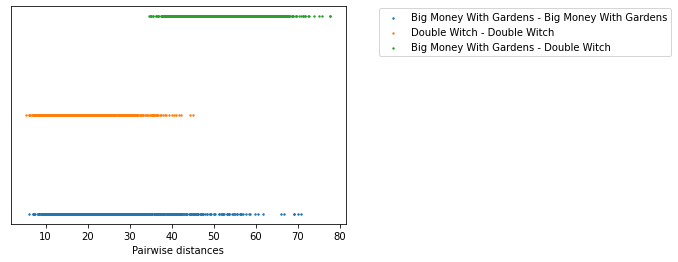

In [29]:
#plot distances along the real line and colour coded
plt.scatter(BMBM, [0] * BMBM.shape[0], s = 2, label = 'Big Money With Gardens - Big Money With Gardens')
plt.scatter(DWDW, [0.01] * DWDW.shape[0], s = 2, label = 'Double Witch - Double Witch')
plt.scatter(BMDW, [0.02] * BMDW.shape[0], s = 2, label = 'Big Money With Gardens - Double Witch')
plt.yticks([])
plt.xlabel('Pairwise distances')
plt.legend(loc = (1.1,0.77))

In [30]:
#compute again our pairwise traces but this time also breakdown by opponent type
pairTraceDistsGranular = sym_trace_combos[['GameID_1','GameID_2','PlayerName_1', 'OpponentName_1', 'PlayerName_2', 'OpponentName_2','dist']]
pairTraceDistsGranular = sym_trace_combos.groupby(['GameID_1','GameID_2','PlayerName_1', 'OpponentName_1', 'PlayerName_2', 'OpponentName_2'])['dist'].sum()
df_pairTraceDistsGranular = pairTraceDistsGranular.reset_index()
print(df_pairTraceDistsGranular)

      GameID_1  GameID_2         PlayerName_1       OpponentName_1  \
0          2.0       2.0  BigMoneyWithGardens          DoubleWitch   
1          2.0       3.0  BigMoneyWithGardens          DoubleWitch   
2          2.0       3.0  BigMoneyWithGardens          DoubleWitch   
3          2.0       3.0          DoubleWitch  BigMoneyWithGardens   
4          2.0       3.0          DoubleWitch  BigMoneyWithGardens   
...        ...       ...                  ...                  ...   
4945      50.0      51.0  BigMoneyWithGardens          DoubleWitch   
4946      50.0      51.0  BigMoneyWithGardens          DoubleWitch   
4947      50.0      51.0          DoubleWitch  BigMoneyWithGardens   
4948      50.0      51.0          DoubleWitch  BigMoneyWithGardens   
4949      51.0      51.0  BigMoneyWithGardens          DoubleWitch   

             PlayerName_2       OpponentName_2       dist  
0             DoubleWitch  BigMoneyWithGardens  45.932217  
1     BigMoneyWithGardens          Doub

In [31]:
results_means = pairTraceDistsGranular.groupby(['PlayerName_1', 'OpponentName_1', 'PlayerName_2', 'OpponentName_2']).mean()
print(results_means)
results_std = pairTraceDistsGranular.groupby(['PlayerName_1', 'OpponentName_1', 'PlayerName_2', 'OpponentName_2']).std()
print(results_std)

PlayerName_1         OpponentName_1       PlayerName_2         OpponentName_2     
BigMoneyWithGardens  DoubleWitch          BigMoneyWithGardens  DoubleWitch            24.429889
                                          DoubleWitch          BigMoneyWithGardens    50.883097
DoubleWitch          BigMoneyWithGardens  BigMoneyWithGardens  DoubleWitch            50.728132
                                          DoubleWitch          BigMoneyWithGardens    18.072101
Name: dist, dtype: float64
PlayerName_1         OpponentName_1       PlayerName_2         OpponentName_2     
BigMoneyWithGardens  DoubleWitch          BigMoneyWithGardens  DoubleWitch            10.876007
                                          DoubleWitch          BigMoneyWithGardens     6.344948
DoubleWitch          BigMoneyWithGardens  BigMoneyWithGardens  DoubleWitch             7.054818
                                          DoubleWitch          BigMoneyWithGardens     6.352721
Name: dist, dtype: float64


In [32]:
#what is happening with the large distance value for BM vs BM? i.e. why the large amount of variance?
#look at piarwise traces for smallest and largest distance values
BMBM_data = df_pairwiseTraceDistances[(df_pairwiseTraceDistances['PlayerName_1'] == 'BigMoneyWithGardens') &
                                        (df_pairwiseTraceDistances['PlayerName_2'] == 'BigMoneyWithGardens')]

smallest_pairwise = BMBM_data.loc[BMBM_data['dist'].idxmin()]
largest_pairwise = BMBM_data.loc[BMBM_data['dist'].idxmax()]
print(smallest_pairwise)
print(largest_pairwise)

GameID_1                       31.0
GameID_2                       46.0
PlayerName_1    BigMoneyWithGardens
PlayerName_2    BigMoneyWithGardens
dist                       6.015253
Name: 4146, dtype: object
GameID_1                       20.0
GameID_2                       39.0
PlayerName_1    BigMoneyWithGardens
PlayerName_2    BigMoneyWithGardens
dist                      70.651037
Name: 3007, dtype: object


In [38]:
def deck_evol_comparison(pairwise_deck_evols, cardTypes):
    #look at evolution of number of cards of each type per round
    noCardTypes = len(cardTypes)
    noOfSubplotsInXDirection = 3
    noOfSubplotsInYDirection = 3
    fig, axs = plt.subplots(noOfSubplotsInXDirection, noOfSubplotsInYDirection)
    for i in range(0,3):
        for j in range(0,3):
            cardIndex = 3*j + i
            cardType = cardTypes[cardIndex]
            card_col_1 = cardType + "_1"
            card_col_2 = cardType + "_2"
            axs[i,j].plot(pairwise_deck_evols['Round'], pairwise_deck_evols[card_col_1], label = 'Player_1')
            axs[i,j].plot(pairwise_deck_evols['Round'], pairwise_deck_evols[card_col_2], label = 'Player_2')
            axs[i,j].set_title(cardType)
            axs[i,j].set_xlabel('Round')
            fig.tight_layout() 

In [42]:
#need to look at deck evolutions for each of these cases
largest_pairwise_decks =  sym_trace_combos[(sym_trace_combos['GameID_1'] == largest_pairwise['GameID_1']) 
                                           & (sym_trace_combos['GameID_2'] == largest_pairwise['GameID_2']) 
                                           & (sym_trace_combos['PlayerName_1'] == largest_pairwise['PlayerName_1']) 
                                           & (sym_trace_combos['PlayerName_2'] == largest_pairwise['PlayerName_2'])]
smallest_pairwise_decks =  sym_trace_combos[(sym_trace_combos['GameID_1'] == smallest_pairwise['GameID_1']) 
                                           & (sym_trace_combos['GameID_2'] == smallest_pairwise['GameID_2']) 
                                           & (sym_trace_combos['PlayerName_1'] == smallest_pairwise['PlayerName_1']) 
                                           & (sym_trace_combos['PlayerName_2'] == smallest_pairwise['PlayerName_2'])]
print(largest_pairwise_decks['dist'].sum())
print(smallest_pairwise_decks['dist'].sum())

70.65103664377304
6.015253102184546


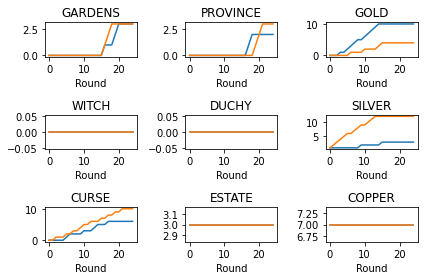

In [40]:
deck_evol_comparison(largest_pairwise_decks, card_types_BigMoneyWithGardens_vs_DoubleWitch)

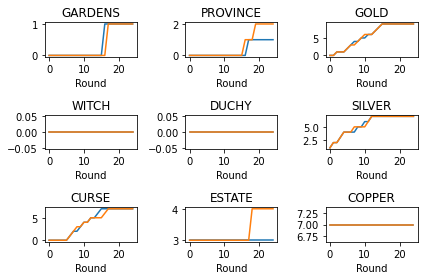

In [43]:
deck_evol_comparison(smallest_pairwise_decks, card_types_BigMoneyWithGardens_vs_DoubleWitch)

In [35]:
#note similarity metric is getting artifically inflated by games that last longer? All games last 24 turns, but if
#difference in deck is quite large and game ends at round 20,this distance is copied for each of the remaining rounds?
#compare samllest and largest differences to see what is driving this.
#do games end quicker when the deck difference is bigger? Which then inflates the distance metric?